In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "svg"
from pymc3 import *

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Distributions, sampling and statistical models

The idea of generating samples from a **probability distribution** is central to everything we do in this course. We use probability distributions to describe variables in a **model** and in Bayesian statistics we use them to express our prior knowledge (or lack thereof) about parameters. Review the [notebook](https://colab.research.google.com/drive/1_b-SaLHrf8_QG7ArjIUjMuk6_DxTnTfU#scrollTo=AE8WwxF9Kb9r&line=1&uniqifier=1) from class and make sure you can answer the following questions:

* What is a **probability distribution**? What does it mean to say that a variable *follows* a given distribution? How do we we denote this? 
* What are some import properties of the **Normal distribution**?
* What does it mean to **sample** from a distribution and how do we generate samples from a distribution in python (using numpy)? * Why have I been using **simulations** to compute various properties of Normal random variables rather than z-scores?
* What is a **model**? What considerations do we make when we develop a model of something?
* What are some examples of things in the world that might be described by linear regression models?


**Exercises**



1.1  Suppose $y_1,\dots,y_k$ are $k$ variables which each follow a Normal distribution with mean $0$ and standard deviation $1$; that is, 
\begin{equation}
y_j \sim {\rm Normal}(0,1)
\end{equation}
for each $j=1,2,\dots,k$. 
 The sum of their squares,
\begin{equation}
z = y_1^2 + y_2^2 + \cdots + y_{k}^2,
\end{equation}
 is said to follow a $\chi^2$-distribution with $k$ degress of freedom. $k$ is the parameter of this distribution and we would write 
 \begin{equation}
 z \sim {\chi}^2(k)
 \end{equation}
to say $z$ follows a $\chi^2$. 


  Write a python function called `chi_sq(k)` which takes the degrees of freedom `k` and returns a sample from the $\chi^2$ distribution. (do this **without** using numpys built-in function for sampling a $\chi^2$ distribution.) If you need to remind yourself of the notation for writing a function, see the [intro to colab notebook](https://colab.research.google.com/drive/1yPxFVsCmu-KhGC8TFUa3q8JdtTZYnay0#scrollTo=zEOa2zDB52Uv) or HW1. 
  
  `numpy` also has a function which generates samples from a $\chi^2$ distribution, called `random.chisquare` which takes the degrees of freedom as an argument and generates a sample. 
Generate $100000$ samples from your function and numpy's function for $k=5$, then compare the histograms to check that they look similar.


 1.2 Let $y$ denote how severe an individual's reaction to a pathogon is (this could be measured by the viral load for example, but will not worry about the units for $y$ for this example). Let $x$ indicate whether that person is vaccinated agianst that pathogan ($x=0$ if they are not and $x=1$ if they are).  Suppose we use the following model to understand how $x$ affects $y$:
 \begin{equation}
 y \sim {\rm Normal}(\mu_2 x + \mu_1 (1-x),\sigma_2 x + \sigma_1 (1-x))
 \end{equation}
 What do each of the parameters $\mu_1$, $\mu_2$, $\sigma_1$ and $\sigma_2$ represent? Is this a linear regression model? 
 
 Suppose $\mu_1 = 10$, $\mu_2 = 7$, $\sigma_1 = 4$ and $\sigma_2 = 2$. By generating samples with numpy, estimate the chance that someone who is vaccinated has a more severe illness than someone who is not. 




Text(0.5, 0, '$\\chi^2$')

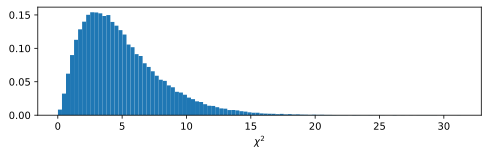

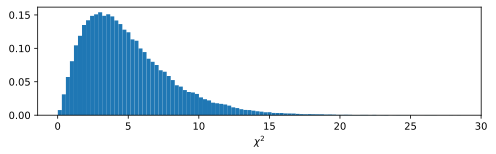

In [ ]:
# 1.1

# defines a chi square function
def chi_sq(k):

  # generates samples of y with k degrees of freedom
  y = np.random.normal(0,1,k)
  
  # creates a chi square sample and returns it
  z = 0
  for samp in y:
    z = z + samp**2

  return z

# creates 2 lists using our chi square function and the built in numpy chi square function
n = 0
sample = []
sample2 = []
while n < 100000:

  sample.append(chi_sq(5))
  sample2.append(np.random.chisquare(5))
  n+=1

# graphs the two lists to compare them
fig,ax = plt.subplots(figsize=(8,2))
fig,bx = plt.subplots(figsize=(8,2))

ax.hist(sample,100,density=True)
ax.set_xlabel("$\chi^2$")
bx.hist(sample2,100,density=True)
bx.set_xlabel("$\chi^2$")


1.2

$\mu_1$ represents the mean of the data for people unvaccinated against the pathogen while $\mu_2$ represents the mean for vaccinated people. Similarly, $\sigma_1$ represents the standard deviation for unvaccinated people while $\sigma_2$ represents the standard deviation of vaccinated people.
This is not a case of linear regression because we have 2 different standard deviations with our 2 populations. 

In [ ]:
# generates samples of unvaxxed data
x = 0
unvax = np.random.normal(7*x + 10*(1-x), 2*x + 4*(1-x),10000)

# generates samples of vaxxed data
x = 1
vax = np.random.normal(7*x + 10*(1-x), 2*x + 4*(1-x),10000)

# counts how many vaxxed people reacted worse than unvaxxed people
count = 0
for n in range(len(vax)):
  if vax[n] > unvax[n]:
    count += 1

print(count/len(vax))

0.2505


# Prior distributions and Bayesian inference for regression models

In Bayesian statistics we use prior distributions to encode any information we have  (or don't have) about the model parameters **before** we see the data. We then use pymc3 to combine our prior information with data (sometimes to test our code or models this is *fake* or simulated data, not real data) to obtain samples from the posterior distribution. 


Review the notebook from [class](https://colab.research.google.com/drive/1q-7__hgESBW2pKbg1_H75nx_V0TYFVus?usp=sharing) and Chapter 9 in the textbook (optional but recommended). Then make sure you can answer the following questions:


* What is one way to ensure samples from our prior distribution are positive numbers? 
* What is a **prior prediction** and how is it different from a **posterior prediction**? 
* What are **uniform**, **weakly informative** and **informative priors**? 
* How do we go about finding weakly informative priors? 
* What code do we use to combine our priors with data to obtain the posterior distribution?

**Exercises**

2.1 Let's suppose we want to model the relationship between male height and weight. Our model is the usual linear regression model
\begin{align}
y = a x + b + \epsilon
\end{align}
where $x$ is height in inches and $y$ in weight in pounds.
What are some weakly informative priors on $a$ and $b$?

**Hint**: Notice that for this model, $b$ does not have a clear interpretation since nobody has a height of zero. It is therefore difficult to translate our prior knowledge about human weight into a prior distribution on $b$. A trick is to define $\delta = x-\bar{x}$ were $\bar{x}$ is a typical, or average height (say around $5.6$ feet). Then, replacing $x$ with $\delta + \bar{x}$, we can rewrite the model as
\begin{align}
y = a (\bar{x} + \delta ) + b + \epsilon  = a \delta + c + \epsilon
\end{align}
where $c = a \bar{x} + b$. 
This also has the form of a regression model, but the predictor is $\delta$ instead of $x$. All we've done is subtract the typical height from every value of $x$. The slope is $a$ and intercept $c$. $c$ can be understood as the weight of someone with the average height. Once you place priors on $c$ and $a$, you can use the properties of Normal distributions to find priors on $b$ in the original model, since $b = c - a\bar{x}$.  This approach of obtaining a new predictor in order to make the model parameters more easily interpretable is called **centering**. 

2.2 We can get some data on male height and weight with the following code:



```
# this first line loads data with information on weight and height, among other things
data = pd.read_csv("https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Earnings/data/earnings.csv")

# now we get numpy arrays with height and weight, but since
# the data file includes both males and females, we take only the men
x = data[data.male == 1].height.values
y = data[data.male == 1].weight.values
```


Use pymc to generate samples from the posterior distribution with the priors you derived in the previous excercise along with 
\begin{equation}
\ln \sigma \sim {\rm Normal}(1,0.4)
\end{equation}
Plot a histogram of $a$ and comment on how the data has changed your belief about the association of height with weight (or how it hasn't if it has not)


2.1

We believe that an inch of height corresponds to about 5 pounds of weight. And we imagine the standard deviation to be around 5 as well. So,
\begin{equation}
a \sim {\rm Normal}(5,5)
\end{equation}

If we say that the average weight of men is 150 for 66 inches, then we guess most men to be within 60 pounds of the mean. So,
\begin{equation}
c \sim {\rm Normal}(150,30)
\end{equation}

In [ ]:
# generates samples for our priors
n = 100000
a = np.random.normal(5,5,n)
c = np.random.normal(150,30,n)
b = np.random.normal(c-66*a, np.sqrt(30**2 + 5**2), n)
print(b)

[-549.19079617 -475.06872139  249.56329801 ... -143.61476504 -422.6233437
 -201.23464194]


We found our prior b to be:

\begin{equation}
b \sim {\rm Normal}(c - 66 \times a, \sqrt{30^2\times 5^2})
\end{equation}

Text(0.5, 0, 'reported weight')

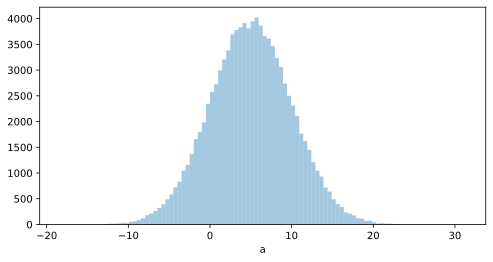

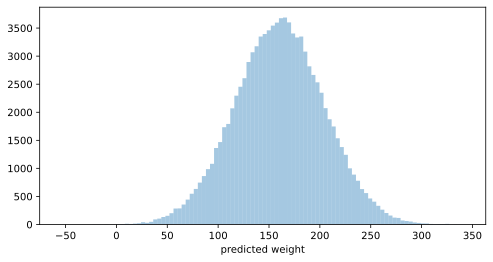

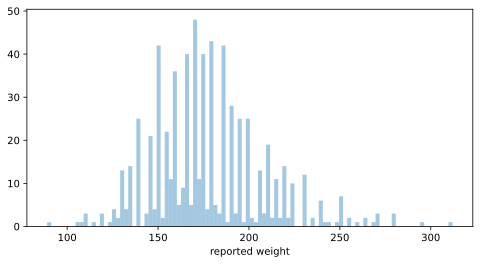

In [ ]:
# 2.2

# this first line loads data with information on weight and height, among other things
data = pd.read_csv("https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Earnings/data/earnings.csv")

# now we get numpy arrays with height and weight, but since
# the data file includes both males and females, we take only the men
x = data[data.male == 1].height.values
y = data[data.male == 1].weight.values

# generates samples of sigma
lnsigma = np.random.normal(1, .04)
sigma = np.exp(lnsigma)

# uses the given heights to predicts weights using our priors
for ele in x:
  sample = (np.random.normal(a*ele + b, sigma))

# plots a histogram of a
fig,ax = plt.subplots(figsize=(8,4))
ax.hist(a,100,alpha=0.4)
ax.set_xlabel('a')

# plots a histogram of weight using our model
fig,bx = plt.subplots(figsize=(8,4))
bx.hist(sample,100,alpha=0.4)
bx.set_xlabel('predicted weight')

# plots a histogram of the weight from the given data
fig,cx = plt.subplots(figsize=(8,4))
cx.hist(y,100,alpha=0.4)
cx.set_xlabel('reported weight')


As we can see from the graphs, our prediction with a=5 seems to be pretty accurate as the graph of the weights predicted from our model and priors roughly matches the reported weights from the data.